# Daily Climate time series data
Ref: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data/notebooks

data location: data/DailyDelhiClimate

## Check data

In [1]:
import os
import numpy as np
import pandas as pd

%cd /src

/src


In [2]:
path_data_train = 'data/DailyDelhiClimate/DailyDelhiClimateTrain.csv'
path_data_test = 'data/DailyDelhiClimate/DailyDelhiClimateTest.csv'

df_train = pd.read_csv(path_data_train)
print(df_train.shape)
df_train.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df_test = pd.read_csv(path_data_test)
print(df_test.shape)
df_test.head()

(114, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [4]:
df_all = pd.concat([df_train, df_test])
df_all.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
df_all.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


plot



In [6]:
def re_organize(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.rename(columns={"meantemp":"temp","wind_speed":"wind","meanpressure":"pressure"})
    return df

df_train = re_organize(df_train)
df_test = re_organize(df_test)
df_all = re_organize(df_all)
print(df_train.columns)
df_train.date.min(), df_train.date.max(), df_test.date.min(), df_test.date.max()

Index(['date', 'temp', 'humidity', 'wind', 'pressure'], dtype='object')


(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-04-24 00:00:00'))

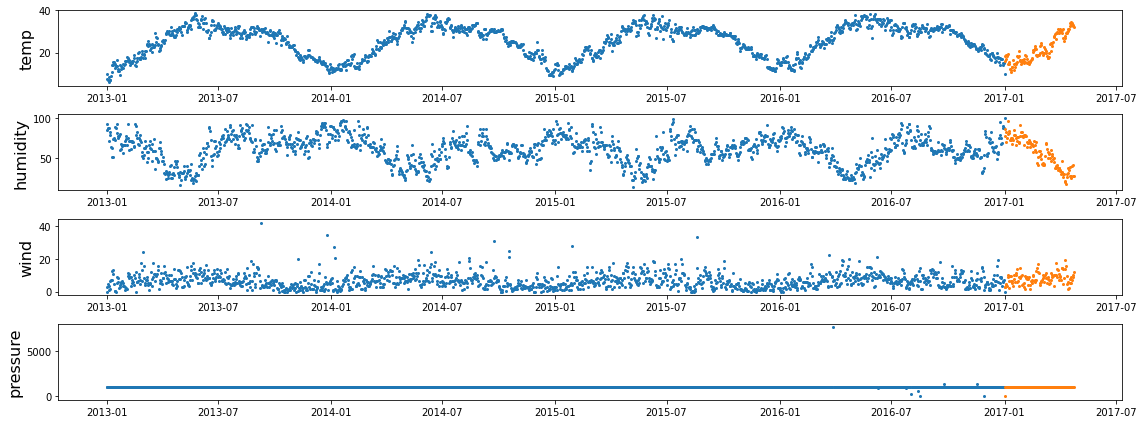

In [7]:
import matplotlib.pyplot as plt

col_vals = ['temp', 'humidity', 'wind', 'pressure']
col_date = 'date'
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot_date(df_train[col_date], df_train[col], marker='o', markersize=2, label='Train')
    axs[i].plot_date(df_test[col_date], df_test[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()


## use PyTorch procedure

#### Logarithmic transformation (JP: 対数差分）
https://stats.biopapyrus.jp/time-series/scale.html <- JP

In [22]:
eps = 1e-11
NAN = np.NAN
def transform_log_ratios(vals):
    aux = np.log((vals[1:]+eps) / (vals[0:-1]+eps))
    return np.hstack( ([NAN], aux))
def inverse_transform_log_ratios(log_ratio, temp_prev):
    return np.multiply(temp_prev, np.exp(log_ratio))

#### normalization (正規化）
https://qiita.com/ta1nakamura/items/f216f3509980592ec833 <- jp

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col_scale = ["humidity","wind","pressure"]
scaler.fit(df_train.loc[:, col_scale])

transformed_train = scaler.transform(df_train.loc[:, col_scale])
transformed_test = scaler.transform(df_test.loc[:, col_scale])
df_train_transformed = pd.DataFrame(transformed_train, columns = col_scale)
df_train_transformed = pd.concat([df_train.loc[:, ['date', 'temp']], df_train_transformed], axis=1)
df_test_transformed = pd.DataFrame(transformed_test, columns = col_scale)
df_test_transformed = pd.concat([df_test.loc[:, ['date', 'temp']], df_test_transformed], axis=1)
df_train_transformed.head()

,date,temp,humidity,wind,pressure
0,2013-01-01,10.000000,0.820957,0.000000,0.132603
1,2013-01-02,7.400000,0.907591,0.070583,0.132881
2,2013-01-03,7.166667,0.849835,0.109743,0.132994
3,2013-01-04,8.666667,0.668867,0.029212,0.132799
4,2013-01-05,6.000000,0.847910,0.087636,0.132712


apply Logarithmic transformation to column 'temp'

In [24]:
df_train_transformed['temp_log'] = transform_log_ratios(df_train_transformed['temp'].values)
df_test_transformed['temp_log'] = transform_log_ratios(df_test_transformed['temp'].values)
df_train_transformed.head()

,date,temp,humidity,wind,pressure,temp_log
0,2013-01-01,10.000000,0.820957,0.000000,0.132603,NaN
1,2013-01-02,7.400000,0.907591,0.070583,0.132881,-0.301105
2,2013-01-03,7.166667,0.849835,0.109743,0.132994,-0.032039
3,2013-01-04,8.666667,0.668867,0.029212,0.132799,0.190044
4,2013-01-05,6.000000,0.847910,0.087636,0.132712,-0.367725


In [25]:
lookback = 6
cols_target = ['temp_log', 'humidity', 'wind', 'pressure']

df_train_transformed = df_train_transformed.reset_index(drop=True)
df_test_transformed = df_test_transformed.reset_index(drop=True)

x = []
t = []
for i in range(1, len(df_train)-lookback-1):
    x.append(df_train_transformed.loc[i:i+lookback-1,cols_target].values)
    t.append(df_train_transformed.loc[i+lookback,cols_target].values.tolist())
X_train = np.array(x).reshape(-1, lookback, len(cols_target))
y_train = np.array(t)

x = []
t = []
for i in range(len(df_test)-lookback-1):
    x.append(df_test_transformed.loc[i:i+lookback-1,cols_target].values)
    t.append(df_test_transformed.loc[i+lookback,cols_target].values.tolist())
X_test = np.array(x).reshape(-1, lookback, len(cols_target))
y_test = np.array(t)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [27]:
X_train.shape, X_val.shape, X_test.shape

((1163, 6, 4), (291, 6, 4), (107, 6, 4))

#### Model

In [28]:
import torch
import torch.nn as nn
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, initial_normal=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False).to(device)
        self.fc = nn.Linear(in_features=hidden_size,
                            out_features=num_classes).to(device)

        if initial_normal:
            nn.init.xavier_normal_(self.lstm.weight_ih_l0)
            nn.init.orthogonal_(self.lstm.weight_hh_l0)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out).to(device)

#         h, _ = self.lstm(x)
#         out = self.fc(h[:, -1])

        return out





#### Training

In [29]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [30]:
X_train.shape

(1163, 6, 4)

In [31]:
from sklearn.utils import shuffle
import numpy as np
import torch
import torch.optim as optimizers

np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 2000
batch_size = 256
n_batches_train = X_train.shape[0] // batch_size + 1
n_batches_val = X_val.shape[0] // batch_size + 1
learning_rate = 0.01

input_size = 4
hidden_size = 10
num_layers = 1

num_classes = 4

hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(),lr=0.001)
#                             lr=0.001),
#                             betas=(0.9, 0.999), amsgrad=True)


# criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

#### show model

In [32]:
model

LSTM(
  (lstm): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=4, bias=True)
)

In [33]:
# from torchsummary import summary
from torchsummaryX import summary
inputs = torch.zeros((32, 6, 4)).to(device) # [length, batch_size]
summary(model,inputs)

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -  [32, 6, 10]     640        560
1_fc        [10, 4]      [32, 4]      44         40
---------------------------------------------------
                      Totals
Total params             684
Trainable params         684
Non-trainable params       0
Mult-Adds                600


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 6, 10]",640,560
1_fc,"[10, 4]","[32, 4]",44,40


In [34]:
preds_0 = 0
t_0 = 0

def train_step(x, t):

    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x).to(device)
    loss = criterion(preds.view(-1),t.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

In [36]:
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    x_, y_ = shuffle(X_train, y_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
#         print(start, end)
        loss, _ = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(X_val[start:end], y_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3f}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 0.2, val_loss: 0.188
epoch: 2, loss: 0.186, val_loss: 0.174
epoch: 3, loss: 0.173, val_loss: 0.160
epoch: 4, loss: 0.16, val_loss: 0.147
epoch: 5, loss: 0.146, val_loss: 0.133
epoch: 6, loss: 0.131, val_loss: 0.120
epoch: 7, loss: 0.118, val_loss: 0.106
epoch: 8, loss: 0.104, val_loss: 0.092
epoch: 9, loss: 0.0902, val_loss: 0.078
epoch: 10, loss: 0.0765, val_loss: 0.065
epoch: 11, loss: 0.0629, val_loss: 0.052
epoch: 12, loss: 0.0504, val_loss: 0.041
epoch: 13, loss: 0.039, val_loss: 0.031
epoch: 14, loss: 0.0303, val_loss: 0.024
epoch: 15, loss: 0.0232, val_loss: 0.019
epoch: 16, loss: 0.0183, val_loss: 0.015
epoch: 17, loss: 0.0153, val_loss: 0.014
epoch: 18, loss: 0.0134, val_loss: 0.013
epoch: 19, loss: 0.0126, val_loss: 0.013
epoch: 20, loss: 0.0125, val_loss: 0.013
epoch: 21, loss: 0.0125, val_loss: 0.013
epoch: 22, loss: 0.0124, val_loss: 0.013
epoch: 23, loss: 0.0125, val_loss: 0.013
epoch: 24, loss: 0.0124, val_loss: 0.013
epoch: 25, loss: 0.0123, val_loss: 0.

In [ ]:
model.eval()
x_ = torch.Tensor(X_val).to(device)
preds_val = model(x_).data.cpu().numpy()

In [ ]:
df_preds_val = pd.DataFrame(preds_val, columns=['temp_log', 'humidity', 'wind', 'pressure'])
df_val = pd.DataFrame(y_val, columns=['temp_log', 'humidity', 'wind', 'pressure'])

In [ ]:
import matplotlib.pyplot as plt

col_vals = ['temp_log', 'humidity', 'wind', 'pressure']
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_val.index, df_preds_val[col], marker='o', markersize=2, label='Train')
    axs[i].plot(df_val.index, df_preds_val[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
x_ = torch.Tensor(X_test).to(device)
preds_test = model(x_).data.cpu().numpy()
df_preds_test = pd.DataFrame(preds_test, columns=['temp_log', 'humidity', 'wind', 'pressure'])
df_test = pd.DataFrame(y_test, columns=['temp_log', 'humidity', 'wind', 'pressure'])
print(df_preds_test.shape, df_test.shape)

In [ ]:
import matplotlib.pyplot as plt

col_vals = ['temp_log', 'humidity', 'wind', 'pressure']
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_test.index, df_preds_test[col], marker='o', markersize=2, label='Train')
    axs[i].plot(df_test.index, df_test[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt

col_vals = ['temp_log', 'humidity', 'wind', 'pressure']
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_test.index, df_preds_test[col], marker='o', markersize=2, label='Train')
    axs[i].plot(df_test.index, df_test[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()

In [45]:
df_preds_val = pd.DataFrame(preds_val, columns=['temp_log', 'humidity', 'wind', 'pressure'])
df_val = pd.DataFrame(y_val, columns=['temp_log', 'humidity', 'wind', 'pressure'])

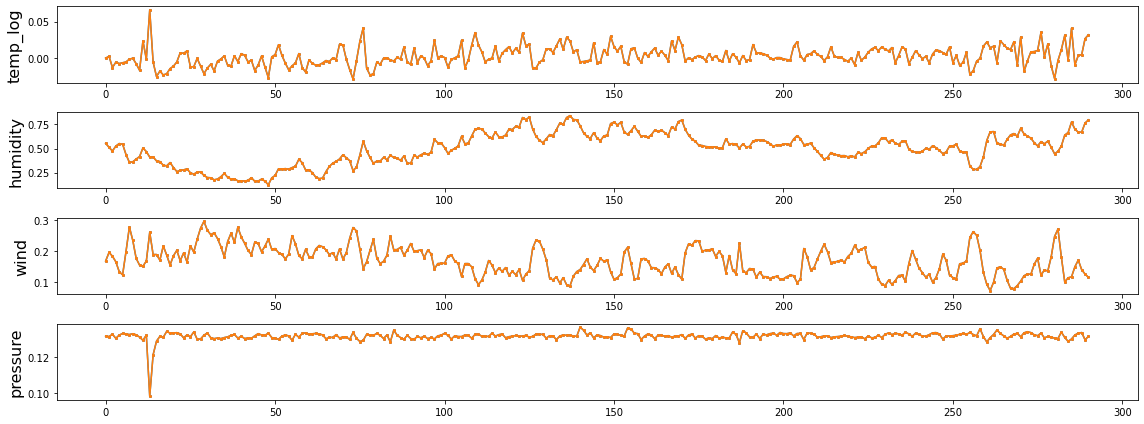

In [46]:
import matplotlib.pyplot as plt

col_vals = ['temp_log', 'humidity', 'wind', 'pressure']
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_val.index, df_preds_val[col], marker='o', markersize=2, label='Train')
    axs[i].plot(df_val.index, df_preds_val[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()

In [49]:
model.eval()
x_ = torch.Tensor(X_test).to(device)
preds_test = model(x_).data.cpu().numpy()
df_preds_test = pd.DataFrame(preds_test, columns=['temp_log', 'humidity', 'wind', 'pressure'])
df_test = pd.DataFrame(y_test, columns=['temp_log', 'humidity', 'wind', 'pressure'])
print(df_preds_test.shape, df_test.shape)

(107, 4) (107, 4)


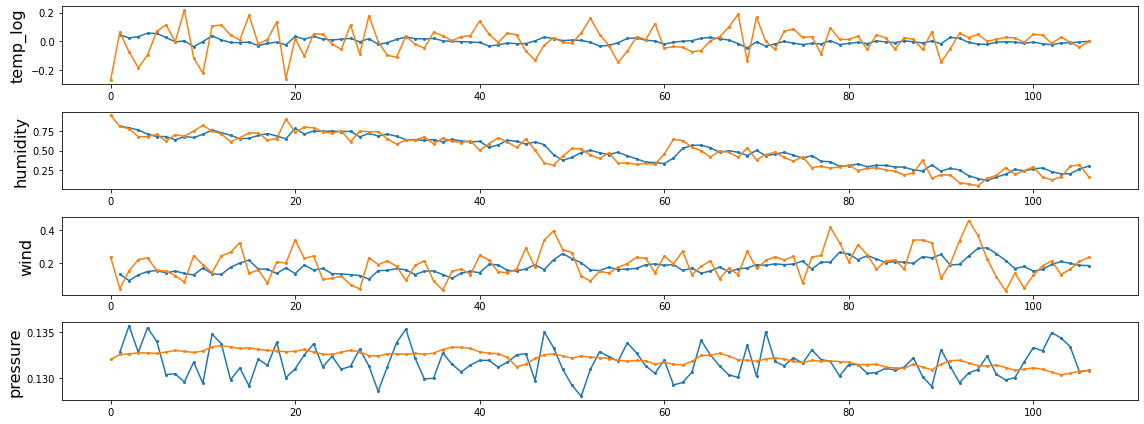

In [50]:
import matplotlib.pyplot as plt

col_vals = ['temp_log', 'humidity', 'wind', 'pressure']
nrows = len(col_vals)
width = 16
height = 6

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_test.index, df_preds_test[col], marker='o', markersize=2, label='Train')
    axs[i].plot(df_test.index, df_test[col], marker='o', markersize=2, label='Test')
    axs[i].set_ylabel(col, fontsize=16)

plt.tight_layout()
plt.show()